# Phần 1. Tổng quan tập dữ liệu

1.1 Nhập các thư viện cần thiết

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC, LinearSVC
from scipy import stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

1.2 Nhập tập dữ liệu

In [6]:
df = pd.read_csv('country_data.csv')

1.3 Tìm hiểu dữ liệu

1.3.1 In ra 5 dòng đầu của tập dữ liệu

In [7]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200


1.3.2 Thông tin tập dữ liệu

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


1.3.3 Kiểm tra số lượng giá trị duy nhất trong mỗi cột

In [9]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
country,167
child_mort,139
exports,147
health,147
imports,151
income,156
inflation,156
life_expec,127
total_fer,138
gdpp,157


# Phần 2: Tiền xử lý dữ liệu

2.1 Kiểm tra và xử lý những giá trị trùng lặp

In [10]:
# Kiểm tra các giá trị trùng lặp
df.duplicated().sum()

0

2.2 Kiểm tra giá trị NaN

In [11]:
# Kiểm tra giá trị NaN
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

2.3 Giá trị ngoại lệ

2.3.1 Kiểm tra giá trị ngoại lệ

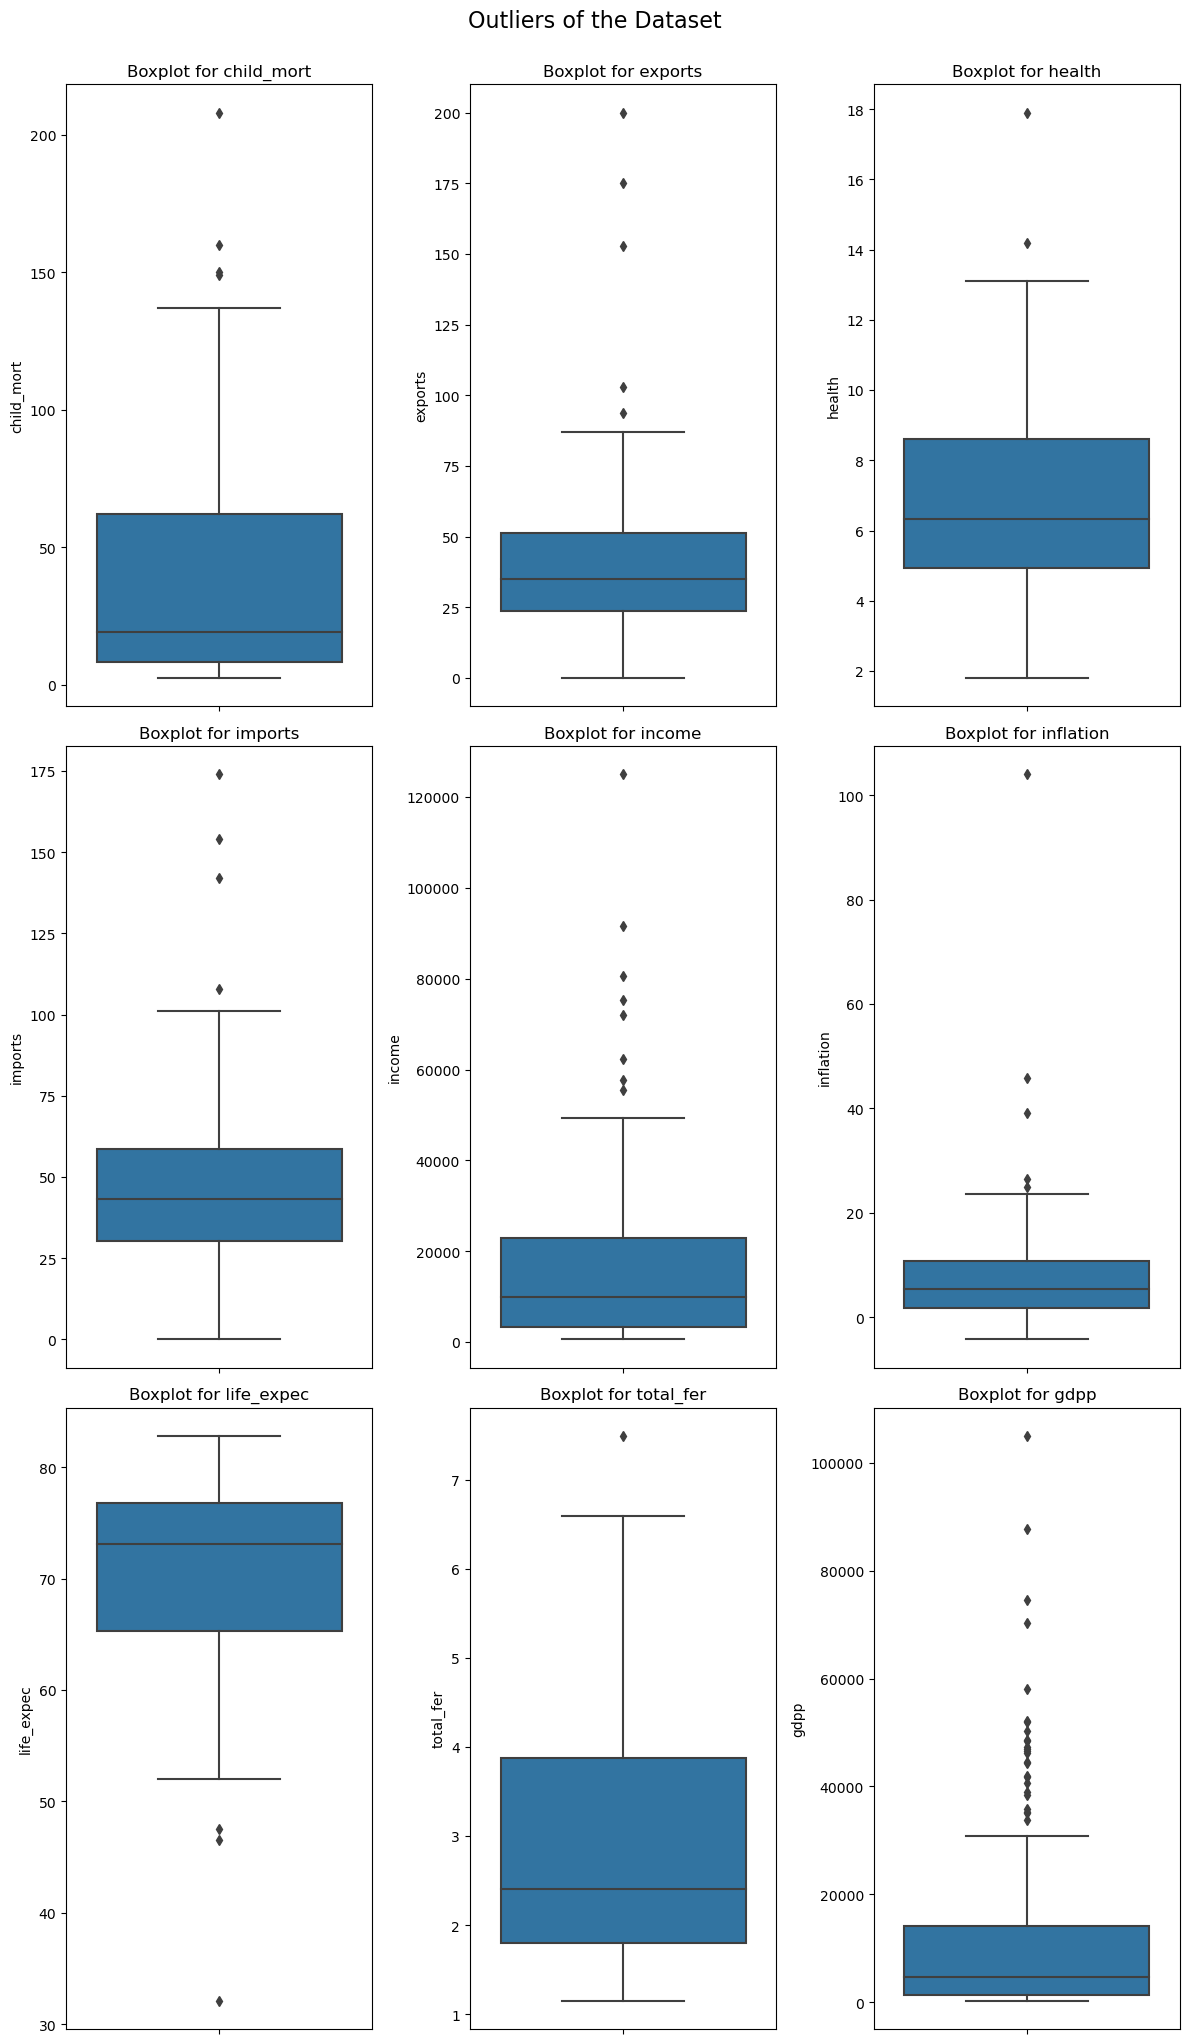

In [12]:

# Kích thước của figure
plt.figure(figsize=(12, 20))

# Vẽ boxplot cho tất cả các cột
for i, column in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset", y=1.02, fontsize=16)
plt.show()

2.3.2 Xử lý giá trị ngoại lệ

⭐ Hàm xử lý giá trị ngoại lệ

In [13]:
def iqr(df, var):
    q1 = np.quantile(df[var], 0.25)
    q3 = np.quantile(df[var], 0.75)
    diff = q3 - q1
    lower_v = q1 - (1.5 * diff)
    upper_v = q3 + (1.5 * diff)
    return df[(df[var] < lower_v) | (df[var] > upper_v)]

⭐ Xử lý giá trị ngoại lệ cột child_mort

In [14]:
# Giá trị trung bình
iqr(df, 'child_mort')['child_mort']

31    149.00
32    150.00
66    208.00
132   160.00
Name: child_mort, dtype: float64

In [15]:
# In ra giá trị ngoại lệ nhỏ nhất của cột
iqr(df, 'child_mort')['child_mort'].min()

149.0

In [16]:
# Tìm giá trị lớn nhất của cột (<172)
df[df['child_mort'] < 149].child_mort.max()

137.0

In [17]:
# Tính phần trăm winsorize cho giá trị 137 trong cột "child_mort"
winsorize_percentile_child_mort = (stats.percentileofscore(df['child_mort'], 137)) / 100

# In ra phần trăm winsorize
print(winsorize_percentile_child_mort)
child_mort_winsorize = winsorize(df.child_mort, (0, (1 - winsorize_percentile_child_mort)))

# Lưu giá trị ngoại lệ đã được xử lý vào cột
df['child_mort'] = child_mort_winsorize

0.9760479041916167


⭐ Xử lý giá trị ngoại lệ cột exports

In [18]:
outlier_min_exports = iqr(df, 'exports')['exports'].min()
df[df['exports'] < outlier_min_exports].exports.max()

86.9

In [19]:
winsorize_percentile_exports = (stats.percentileofscore(df['exports'], 86.9)) / 100

print(winsorize_percentile_exports)
exports_winsorize = winsorize(df.exports, (0, (1 - winsorize_percentile_exports)))

df['exports'] = exports_winsorize

0.9700598802395208


⭐ Xử lý giá trị ngoại lệ cột health

In [20]:
outlier_min_health = iqr(df, 'health')['health'].min()
df[df['health'] < outlier_min_health].health.max()

13.1

In [21]:
winsorize_percentile_health = (stats.percentileofscore(df['health'], 13.1)) / 100

print(winsorize_percentile_health)
health_winsorize = winsorize(df.health, (0, (1 - winsorize_percentile_health)))

df['health'] = health_winsorize

0.9880239520958082


⭐ Xử lý giá trị ngoại lệ cột imports

In [22]:
outlier_min_imports = iqr(df, 'imports')['imports'].min()
df[df['imports'] < outlier_min_imports].imports.max()

101.0

In [23]:
winsorize_percentile_imports = (stats.percentileofscore(df['imports'], 101)) / 100

print(winsorize_percentile_imports)
imports_winsorize = winsorize(df.imports, (0, (1 - winsorize_percentile_imports)))

df['imports'] = imports_winsorize

0.9760479041916167


⭐ Xử lý giá trị ngoại lệ cột income

In [24]:
outlier_min_income = iqr(df, 'income')['income'].min()
df[df['income'] < outlier_min_income].income.max()

49400

In [25]:
winsorize_percentile_income = (stats.percentileofscore(df['income'], 49400)) / 100

print(winsorize_percentile_income)
income_winsorize = winsorize(df.income, (0, (1 - winsorize_percentile_income)))

df['income'] = income_winsorize

0.9520958083832335


⭐ Xử lý giá trị ngoại lệ cột inflation

In [26]:
outlier_min_inflation = iqr(df, 'inflation')['inflation'].min()
df[df['inflation'] < outlier_min_inflation].inflation.max()

23.6

In [27]:
winsorize_percentile_inflation = (stats.percentileofscore(df['inflation'], 23.6)) / 100

print(winsorize_percentile_inflation)
inflation_winsorize = winsorize(df.inflation, (0, (1 - winsorize_percentile_inflation)))

df['inflation'] = income_winsorize

0.9700598802395208


⭐ Xử lý giá trị ngoại lệ cột life_expec

In [28]:
iqr(df, 'life_expec')['life_expec']

31   47.50
66   32.10
87   46.50
Name: life_expec, dtype: float64

In [29]:
outlier_min_life_expec = iqr(df, 'life_expec')['life_expec'].max()

df[df['life_expec'] > outlier_min_life_expec].life_expec.min()

52.0

In [30]:
df.at[31, 'life_expec'] = 52
df.at[66, 'life_expec'] = 52
df.at[87, 'life_expec'] = 52

⭐ Xử lý giá trị ngoại lệ cột total_fer

In [31]:
outlier_min_total_fer = iqr(df, 'total_fer')['total_fer'].min()
df[df['total_fer'] < outlier_min_total_fer].total_fer.max()

6.59

In [32]:
winsorize_percentile_total_fer = (stats.percentileofscore(df['total_fer'], 6.59)) / 100

print(winsorize_percentile_total_fer)
total_fer_winsorize = winsorize(df.total_fer, (0, (1 - winsorize_percentile_total_fer)))

df['total_fer'] = total_fer_winsorize

0.9940119760479041


⭐ Xử lý giá trị ngoại lệ cột gdpp

In [33]:
outlier_min_gdpp = iqr(df, 'gdpp')['gdpp'].min()
df[df['gdpp'] < outlier_min_gdpp].gdpp.max()

30800

In [34]:
winsorize_percentile_gdpp = (stats.percentileofscore(df['gdpp'], 30800)) / 100

print(winsorize_percentile_total_fer)
gdpp_winsorize = winsorize(df.gdpp, (0, (1 - winsorize_percentile_gdpp)))

df['gdpp'] = gdpp_winsorize

0.9940119760479041


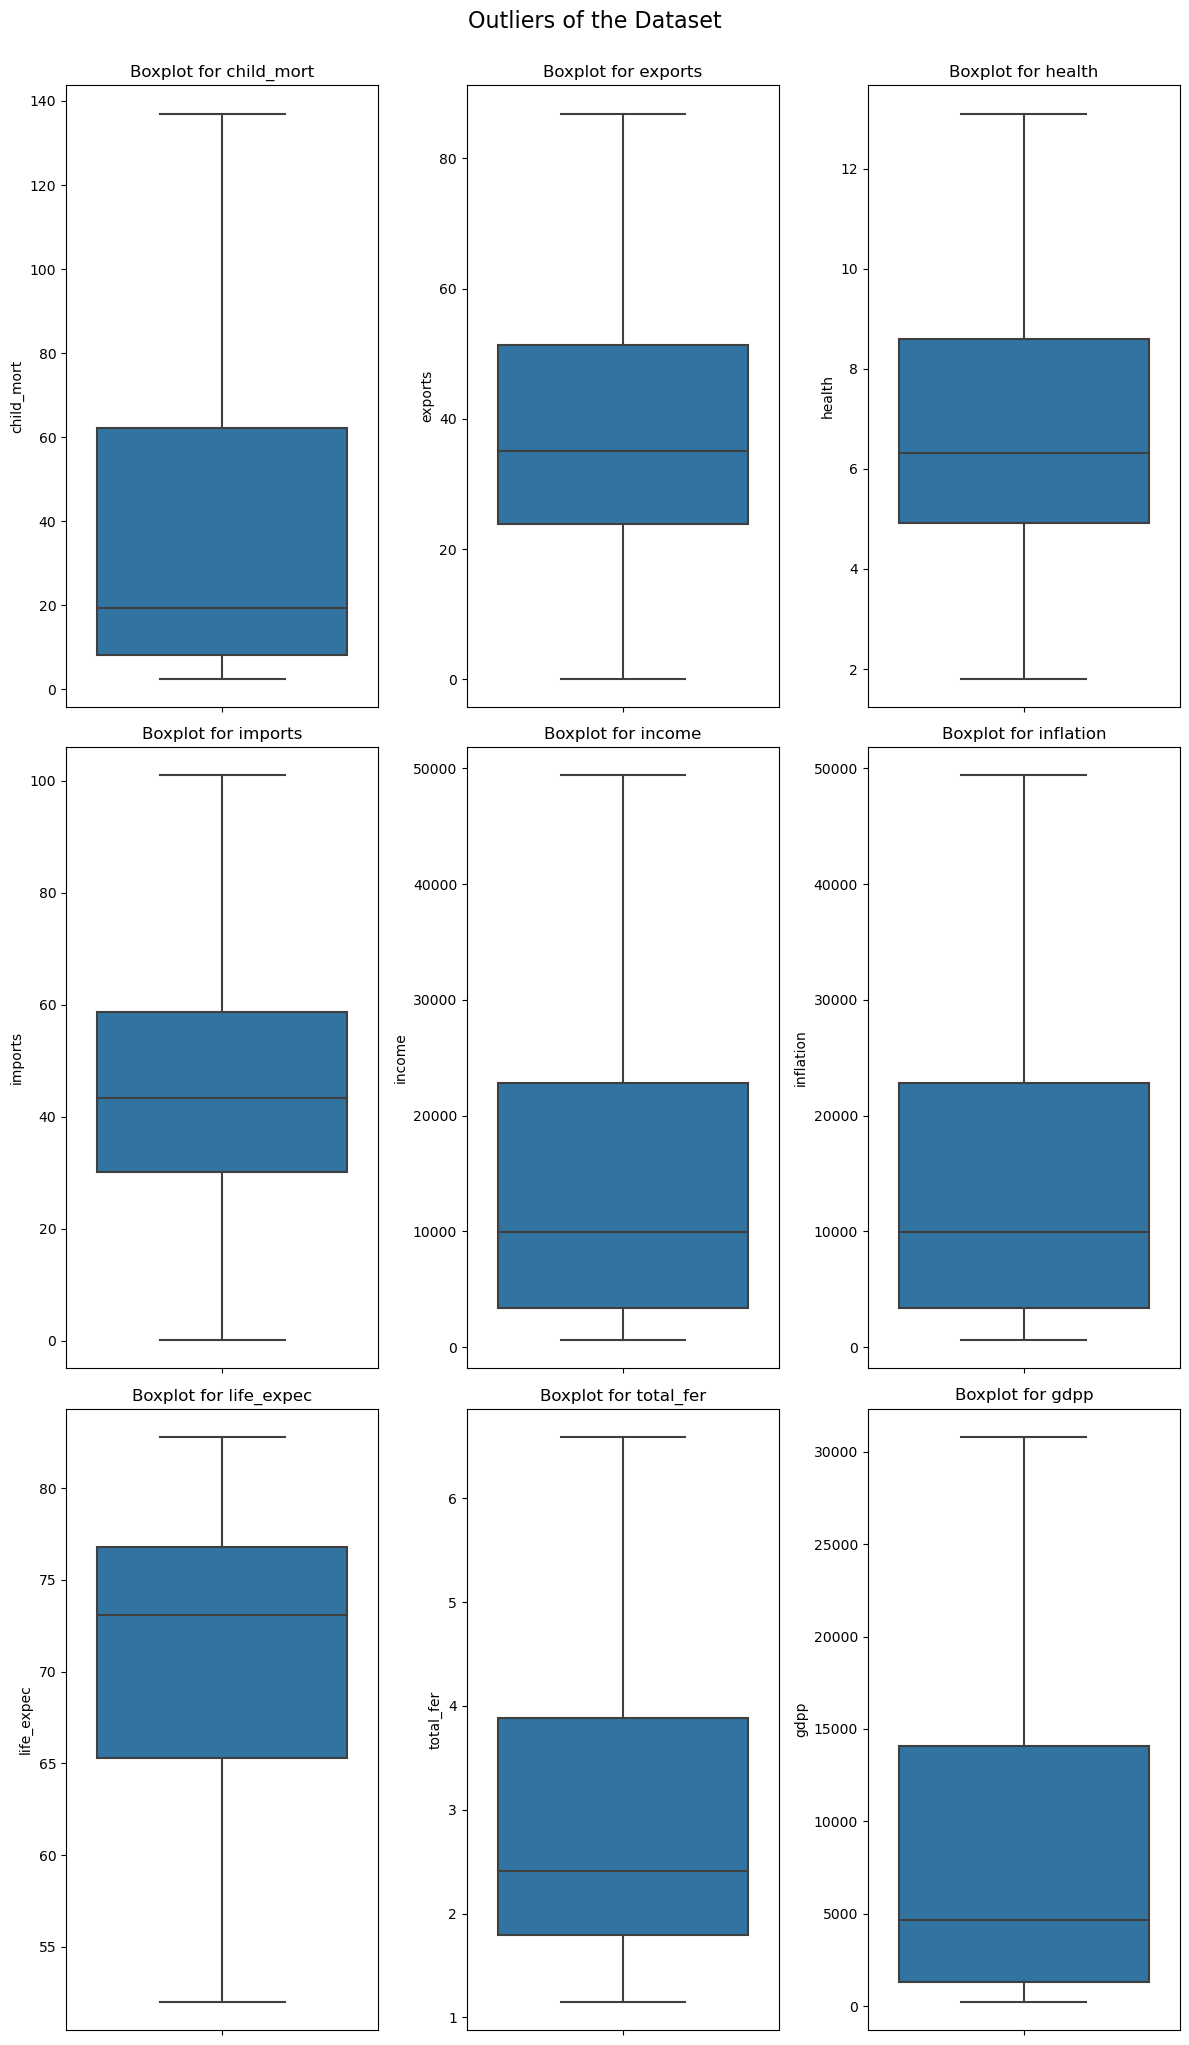

In [35]:

# Kích thước của figure
plt.figure(figsize=(12, 20))

# Vẽ boxplot cho tất cả các cột
for i, column in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset", y=1.02, fontsize=16)
plt.show()

2.4 Lưu tập dữ liệu sau khi đã tiền xử lý

In [36]:
# df.to_csv('country_data_processed.csv', index=False)

# Phần 3: Mối tương quan của tập dữ liệu

In [37]:
df2 = df.copy()

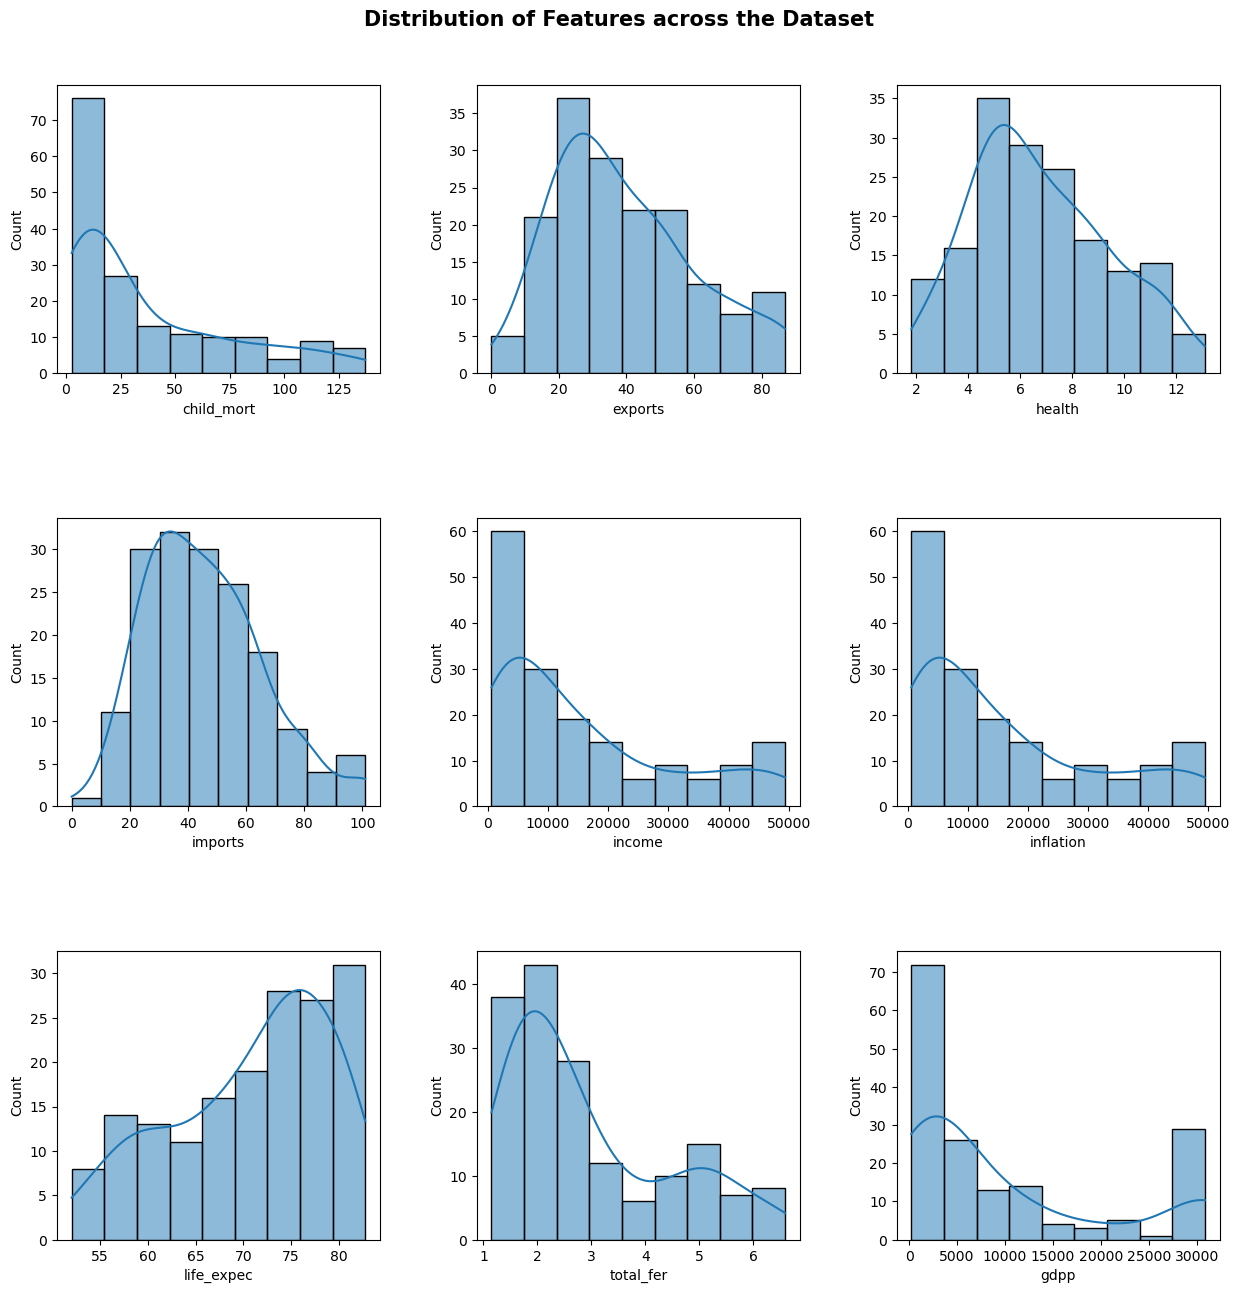

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={"hspace": 0.5, "wspace": 0.3})
for i, col in enumerate(df2.drop(columns='country')):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    
fig.suptitle('Distribution of Features across the Dataset', fontsize=15, fontweight='bold', y=0.93)
plt.show()

3.x Biểu đồ thể hiện mức độ tương quan của toàn bộ tập dữ liệu

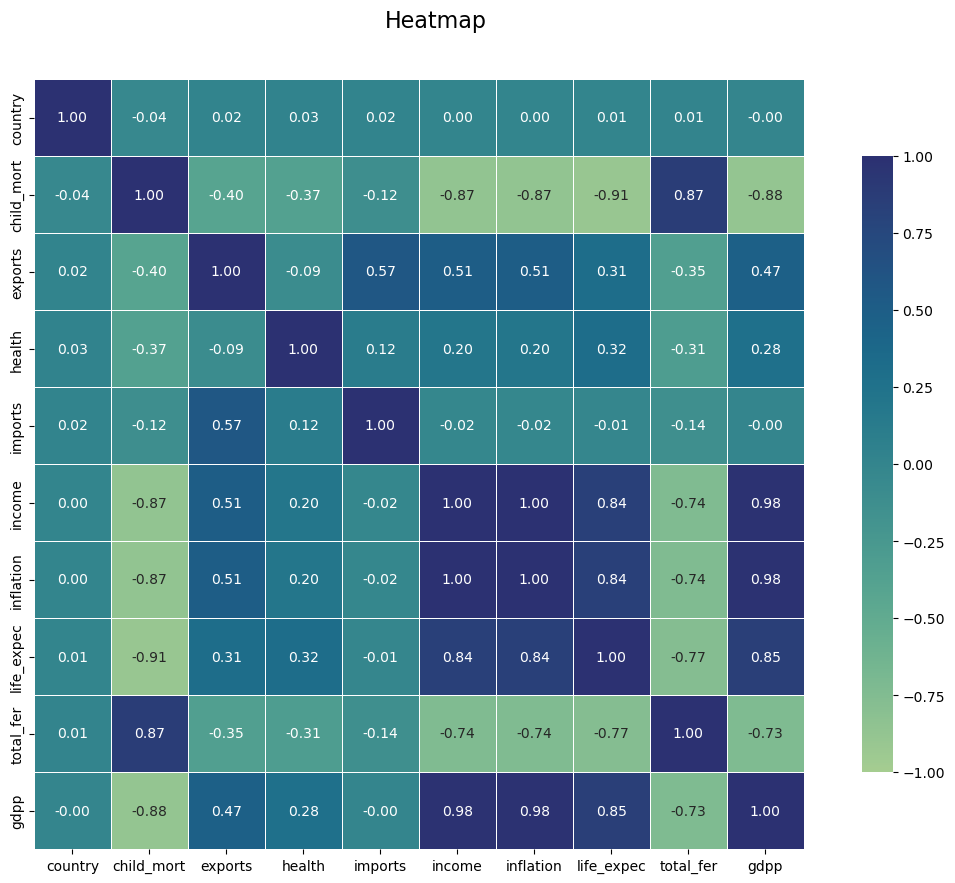

In [47]:
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()

# Sử dụng LabelEncoder để chuyển đổi cột "country" thành dữ liệu số
label_encoder = LabelEncoder()
df_encoded['country'] = label_encoder.fit_transform(df['country'])

# Tạo heatmap cho ma trận tương quan
plt.figure(figsize=(15, 10))
sns.heatmap(df_encoded.corr(method='spearman', min_periods=1), annot=True, cmap="crest", linewidths=.5, fmt=".2f", vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.8})

plt.suptitle("Heatmap", y=0.95, fontsize=16)  # Thêm tiêu đề chung
plt.show()

# Phần 4. Mô hình

4.1.x Giảm chiều dữ liệu (PCA)